In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir("..")
import src.models as models
import src.utils as utils
import src.main as main
from tqdm import tqdm
from scipy.ndimage import convolve1d


%load_ext autoreload
%autoreload 

logger = utils.setup_logger(__name__)
logger(".")

2024-09-24 16:31:06 | .


---

## Settings
---

In [7]:
class Settings:
    num = 100
    load = True
    idx = 0
    use_bias = False
    
args = Settings()

if args.load:
    info, autoencoder = models.load_session(idx=args.idx)
    dim_ei = info["dim_ei"]
    dim_ca3 = info["dim_ca3"]
    dim_ca1 = info["dim_ca1"]
    dim_eo = info["dim_eo"]

    num_samples = info["num_samples"]

    K_lat = info["K_lat"]
    beta = info["beta"]
    K = info["K"]

    # get parameters
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)

    logger(f"{autoencoder=}")

    logger("<<< Loaded session >>>")
else:
    dim_ei = 50
    dim_ca3 = 50 
    dim_ca1 = 50
    dim_eo = dim_ei

    # data settings
    num_samples = 2000

    # model hyper-parameters
    K = 5
    K_lat = 15
    beta = 60

    # autoencoder
    autoencoder = models.Autoencoder(input_dim=dim_ei,
                              encoding_dim=dim_ca1,
                              activation=None,
                              K=K_lat,
                              beta=beta,
                              use_bias=args.use_bias)
    logger(f"%Autoencoder: {autoencoder}")

2024-09-24 16:47:15 | Pre-selected session: [0]
2024-09-24 16:47:15 | info:
2024-09-24 16:47:15 | autoencoder=Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
  )
)
2024-09-24 16:47:15 | <<< Loaded session >>>


{'K': 5,
 'K_lat': 15,
 'beta': 60,
 'dim_ca1': 50,
 'dim_ca3': 50,
 'dim_ei': 50,
 'dim_eo': 50,
 'epochs': 500,
 'loss_ae': 0.05726,
 'num_reconstructions': 1,
 'num_samples': 10000}


### training **AE** from scratch

#### Dataset

In [159]:
training_samples = utils.sparse_stimulus_generator(N=num_samples,
                                                   K=K,
                                                   size=dim_ei,
                                                   plot=False)
test_samples = utils.sparse_stimulus_generator(N=num_samples,
                                               K=K,
                                               size=dim_ei,
                                               plot=False)

# dataset for btsp
num_btsp_samples = args.num
training_sample_btsp = training_samples[np.random.choice(
                        range(training_samples.shape[0]),
                        num_btsp_samples, replace=False)]


logger("<<< Data generated >>>")

2024-09-02 18:49:04 | <<< Data generated >>>


In [134]:
""" AE training """

epochs = 400
loss_ae, autoencoder = utils.train_autoencoder(
                training_data=training_samples,
                test_data=test_samples,
                model=autoencoder,
                epochs=int(epochs),
                batch_size=10, learning_rate=1e-3)
logger(f"<<< Autoencoder trained [loss={loss_ae:.4f}] >>>")



Epoch [400], Loss: 0.0085, Test: 0.0369: 100%|█████████████████████████████████████████████████████████████| 400/400 [01:10<00:00,  5.69it/s]
2024-09-01 13:02:39 | <<< Autoencoder trained [loss=1.7057] >>>


2024-09-01 13:00:21 | %MTL: MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=False, lr=1.0,beta=60, alpha=0.01, K_l=15, K_o=10


0 0


/Users/daniekru/Research/lab/KAMemory/src/utils.py:401: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:k+1], dtype=torch.float32).detach()


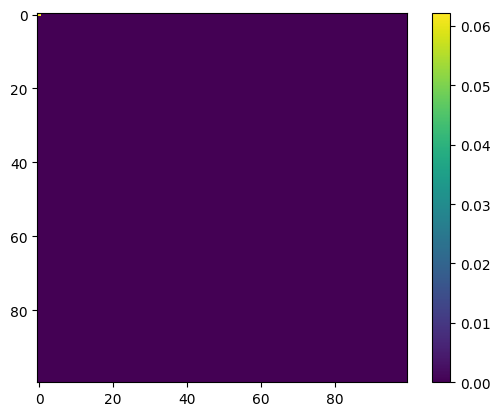

In [133]:
""" mtl training """

# get weights from the autoencoder
if args.use_bias:
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)
else:
    W_ei_ca1, W_ca1_eo = autoencoder.get_weights(bias=False)
    B_ei_ca1 = None
    B_ca1_eo = None

# make model
model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=dim_ca3,
            lr=1.,
            K_lat=K_lat,
            K_out=K,
            beta=beta)

logger(f"%MTL: {model}")

# train model | testing = training without backprop
epochs = 1
for _ in range(epochs):
   # _, model = utils.testing(data=training_sample_btsp,
   #                                 model=model,
   #                                 column=True)

    #model.pause_lr()
    acc, _, = utils.progressive_testing(data=training_sample_btsp,
                                model=model)

plt.imshow(acc, vmin=0)
plt.colorbar();

#### **AE** training

In [5]:
# train autoencoder
if not args.load:
    epochs = 400
    loss_ae, autoencoder = utils.train_autoencoder(
                    training_data=training_samples,
                    test_data=test_samples,
                    model=autoencoder,
                    epochs=int(epochs),
                    batch_size=10, learning_rate=1e-3)
    logger(f"<<< Autoencoder trained [loss={loss_ae:.4f}] >>>")

# reconstruct data
out_ae, latent_ae = utils.reconstruct_data(data=training_sample_btsp,
                                num=num_btsp_samples,
                                model=autoencoder,
                                show=False, 
                                plot=False)

100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 8181.29it/s]


In [3]:
W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)

## Sim 2
---
making the $\alpha$**-plot** training each pattern only once

#### attempt 1

2024-08-27 18:16:51 | %MTL: MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=False, lr=1.0,beta=60, alpha=0.01, K_l=15, K_o=5
100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 6744.88it/s]


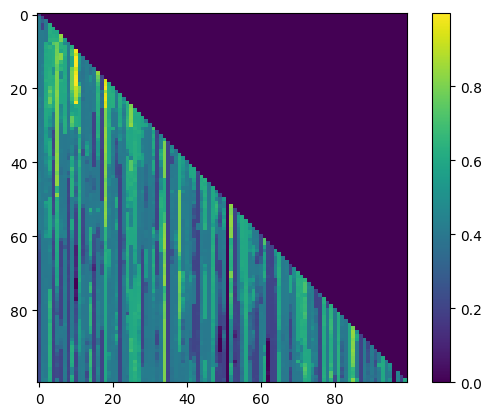

In [4]:
""" mtl training """

# get weights from the autoencoder
if args.use_bias:
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)
else:
    W_ei_ca1, W_ca1_eo = autoencoder.get_weights(bias=False)
    B_ei_ca1, B_ca1_eo = None, None
    

#logger.debug(f"{W_ei_ca1.shape=}\n{type(W_ei_ca1)}")

# make model
model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=dim_ca3,
            lr=1.,
            K_lat=K_lat,
            K_out=K,
            beta=beta)

logger(f"%MTL: {model}")

# train model | testing = training without backprop
epochs = 1
for _ in range(epochs):
   # _, model = utils.testing(data=training_sample_btsp,
   #                                 model=model,
   #                                 column=True)

    #model.pause_lr()
    loss_mtl, _, _ = utils.testing(data=training_sample_btsp,
                                model=model,
                                column=True,
                                use_tensor=True,
                                progressive_test=True)
    #logger(f"<<< MTL trained [{loss_mtl:.3f}] >>>")

# reconstruct data
model.pause_lr()
out_mtl, latent_mtl = utils.reconstruct_data(
                                data=training_sample_btsp,
                                num=num_btsp_samples,
                                model=model,
                                column=True,
                                plot=False)

plt.imshow(loss_mtl, vmin=0)
plt.colorbar();

#### attempt 2

2024-08-27 18:17:02 | %MTL: MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=False, lr=1.0,beta=60, alpha=0.01, K_l=15, K_o=5


torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])


/Users/daniekru/Research/lab/KAMemory/src/utils.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:k+1], dtype=torch.float32).detach()


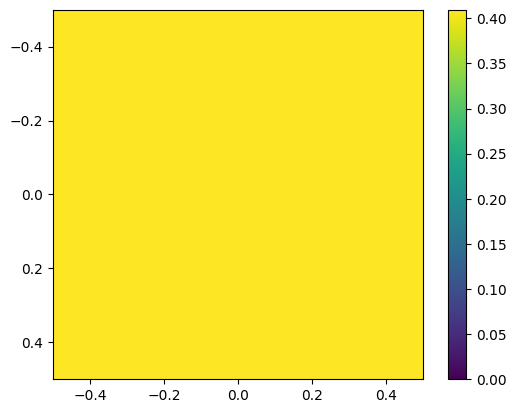

In [5]:
""" mtl training """

# get weights from the autoencoder
if args.use_bias:
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)
else:
    W_ei_ca1, W_ca1_eo = autoencoder.get_weights(bias=False)
    B_ei_ca1 = None
    B_ca1_eo = None

# make model
model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=dim_ca3,
            K_lat=K_lat,
            K_out=K,
            beta=beta)

logger(f"%MTL: {model}")

# train model | testing = training without backprop
epochs = 1
for _ in range(epochs):
   # _, model = utils.testing(data=training_sample_btsp,
   #                                 model=model,
   #                                 column=True)

    #model.pause_lr()
    acc, _, = utils.progressive_testing(data=training_sample_btsp,
                                model=model)

plt.imshow(acc, vmin=0)
plt.colorbar();

In [9]:
acc.shape

torch.Size([1, 1])

100%|██████████████████████████████████████████████| 10/10 [00:10<00:00,  1.04s/it]


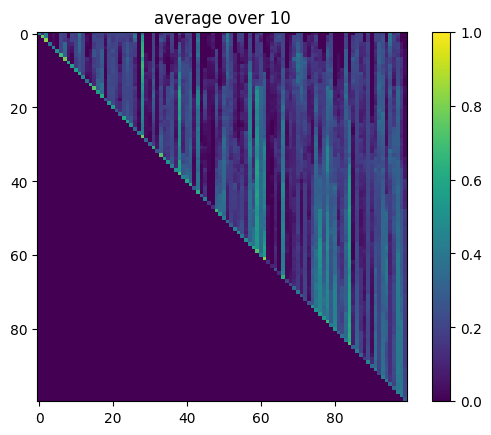

In [28]:
NUM_REP = 10

acc = np.zeros((args.num, args.num))
for _ in tqdm(range(NUM_REP)):
    model = models.MTL(W_ei_ca1=W_ei_ca1,
                W_ca1_eo=W_ca1_eo,
                B_ei_ca1=B_ei_ca1,
                B_ca1_eo=B_ca1_eo,
                dim_ca3=dim_ca3,
                K_lat=K_lat,
                K_out=K,
                beta=beta)
    
    #logger(f"%MTL: {model}")
    
    # train model | testing = training without backprop
    acc_epoch, _, _ = utils.testing(data=training_sample_btsp,
                                model=model,
                                column=True,
                                use_tensor=False,
                                progressive_test=True)

    acc += acc_epoch.numpy()
    
acc /= NUM_REP
plt.imshow(acc, vmin=0, vmax=1)
plt.title(f"average over {NUM_REP}")
plt.colorbar();

#### Plotting

In [ ]:
### """ plotting """

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 5), sharex=True)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
is_squash = False

utils.plot_squashed_data(
    data=training_sample_btsp,
                         ax=ax1,
                         title="Patterns", squash=is_squash)
utils.plot_squashed_data(data=latent_ae, ax=ax2,
                         title="Autoencoder",
                         squash=is_squash)
utils.plot_squashed_data(data=latent_mtl, ax=ax3,
                         title="MTL", squash=is_squash)

fig.suptitle(f"Latent layers - $K_l=${K_lat} $\\beta=${autoencoder._beta}")

#
fig2, (ax12, ax22, ax32) = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
is_squash = False

utils.plot_squashed_data(
    data=training_sample_btsp,
                         ax=ax12,
                         title="Patterns", squash=is_squash)
utils.plot_squashed_data(data=out_ae, ax=ax22,
                         title="Autoencoder",
                         squash=is_squash)
utils.plot_squashed_data(data=out_mtl, ax=ax32,
                         title="MTL",
                         squash=is_squash)

fig2.suptitle(f"Data reconstruction of {num_btsp_samples} patterns - $K=${K} $\\beta=${autoencoder._beta}",
              fontsize=15)

#
fig3, (ax13) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
cbar = plt.colorbar(
    ax13.imshow(training_sample_btsp - out_mtl,
                cmap="seismic",
                aspect="auto"))
ax13.set_yticks(range(num_btsp_samples))

cbar.set_label("Error")
ax13.set_title("pattern - mtl")
plt.show()



In [ ]:
plt.imshow(loss_mtl, vmin=0)
plt.colorbar();

## $\alpha$-plot
---
training of the MTL for different values of $\alpha$, and average over multiple repetitions

In [8]:
""" data """

num_samples = 200
num_rep = 5
datasets = []

stimuli = utils.sparse_stimulus_generator(N=num_samples,
                                          K=K,
                                          size=dim_ei,
                                          plot=False)

datasets = []
for k in range(num_samples):
    data = torch.tensor(stimuli[:k+1], dtype=torch.float32)
    dataloader = DataLoader(TensorDataset(data),
                            batch_size=1,
                            shuffle=False)
    datasets += [dataloader]


In [16]:
beta, alpha

(60, np.float64(1.0))

In [10]:
""" run """

num_alphas = 10
if num_alphas < 2:
    alphas = [0.4]
else:
    #alphas = [0.01, 0.04, 0.08, 0.2, 0.6, 1.]
    alphas = np.around(np.linspace(0.001, 1., num_alphas), 2)
    num_alphas = len(alphas)

outputs = np.zeros((num_rep, num_alphas, num_samples, num_samples))

for l in tqdm(range(num_rep)):
    for h, alpha in enumerate(alphas):

        # data
        stimuli = utils.sparse_stimulus_generator(N=num_samples,
                                                  K=K,
                                                  size=dim_ei,
                                                  plot=False)

        datasets = []
        for k in range(num_samples):
            data = torch.tensor(stimuli[:k+1], dtype=torch.float32)
            dataloader = DataLoader(TensorDataset(data),
                                    batch_size=1,
                                    shuffle=False)
            datasets += [dataloader]

        # run
        for i in tqdm(range(num_samples), disable=True):

            # make model
            model = models.MTL(W_ei_ca1=W_ei_ca1,
                        W_ca1_eo=W_ca1_eo,
                        B_ei_ca1=B_ei_ca1,
                        B_ca1_eo=B_ca1_eo,
                        dim_ca3=dim_ca3,
                        K_lat=K_lat,
                        K_ca3=10,
                        K_out=K,
                        beta=beta,
                        alpha=alpha)

            # train a dataset with pattern index 0.. i
            model.eval()
            with torch.no_grad():

                # one pattern at a time
                for batch in datasets[i]:
                    # forward
                    _ = model(batch[0].reshape(-1, 1))

            # test a dataset with pattern index 0.. i 
            model.pause_lr()
            model.eval()
            with torch.no_grad():
                # one pattern at a time
                for j, batch in enumerate(datasets[i]):
                    x = batch[0].reshape(-1, 1)

                    # forward
                    y = model(x)
                    # logger.debug(f"{x.shape}, {y.shape}")

                    # record : cosine similarity
                    # outputs[l, h, i, j] = (y.T @ x) / \
                    #     (torch.norm(x) * torch.norm(y))

                    value = (y.T @ x) / \
                        (torch.norm(x) * torch.norm(y))

                    outputs[l, h, i, j] = (value.item() - 0.2) / 0.8

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:47<00:00, 45.53s/it]


#### Plot

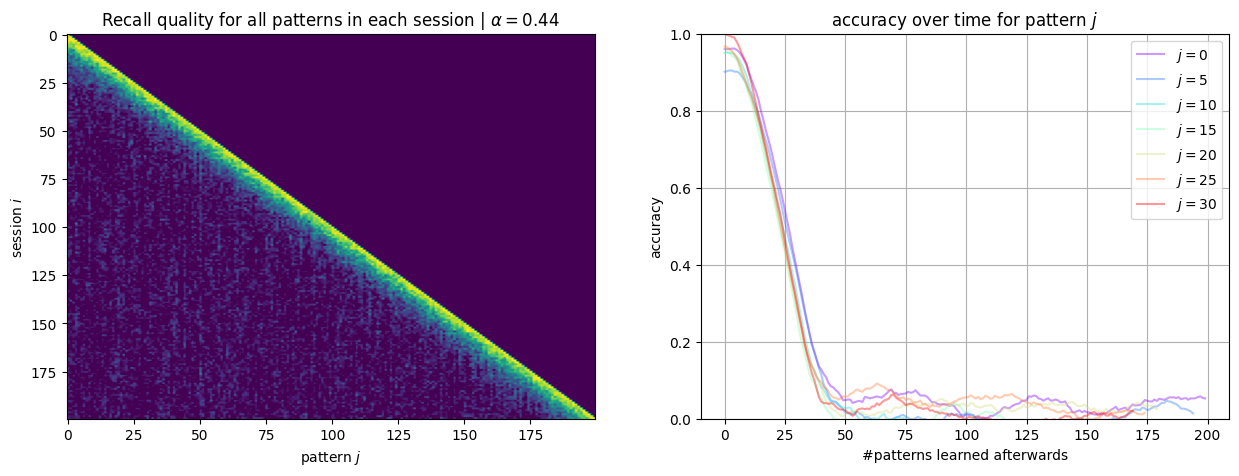

In [11]:
i = 4
outputs1 = outputs.mean(axis=0)[i]
# -> (sample, sample)

fig0 = plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(outputs1, cmap="viridis",
           vmin=0, vmax=1, aspect="auto")
plt.title(f"Recall quality for all patterns in each session | $\\alpha=${alphas[i]}")
plt.xlabel("pattern $j$")
plt.ylabel("session $i$")


plt.subplot(122)
# plt.axhline(0.1, color="r", linestyle="--",
#             alpha=0.2)
# smoothing
num_p = 7
jumps = 5
colors = plt.cm.rainbow(np.linspace(0, 1, num_p))
for di, d in enumerate(range(0, jumps*num_p, jumps)):
    output_d = outputs1[d:, d] # selection of one pattern
    nsmooth = 30
    padded_d = np.pad(output_d, (nsmooth-1, 0), mode="edge")
    output_d = np.convolve(padded_d,
                          np.ones(nsmooth)/nsmooth,
                          mode="valid")
    plt.plot(output_d, '-', label=f"$j=${d}", alpha=0.4,
             color=colors[di])

plt.ylim(0., 1)
plt.ylabel("accuracy")
plt.xlabel("#patterns learned afterwards")
plt.legend()
plt.title("accuracy over time for pattern $j$")
plt.grid()

plt.show()


## Memory capacity

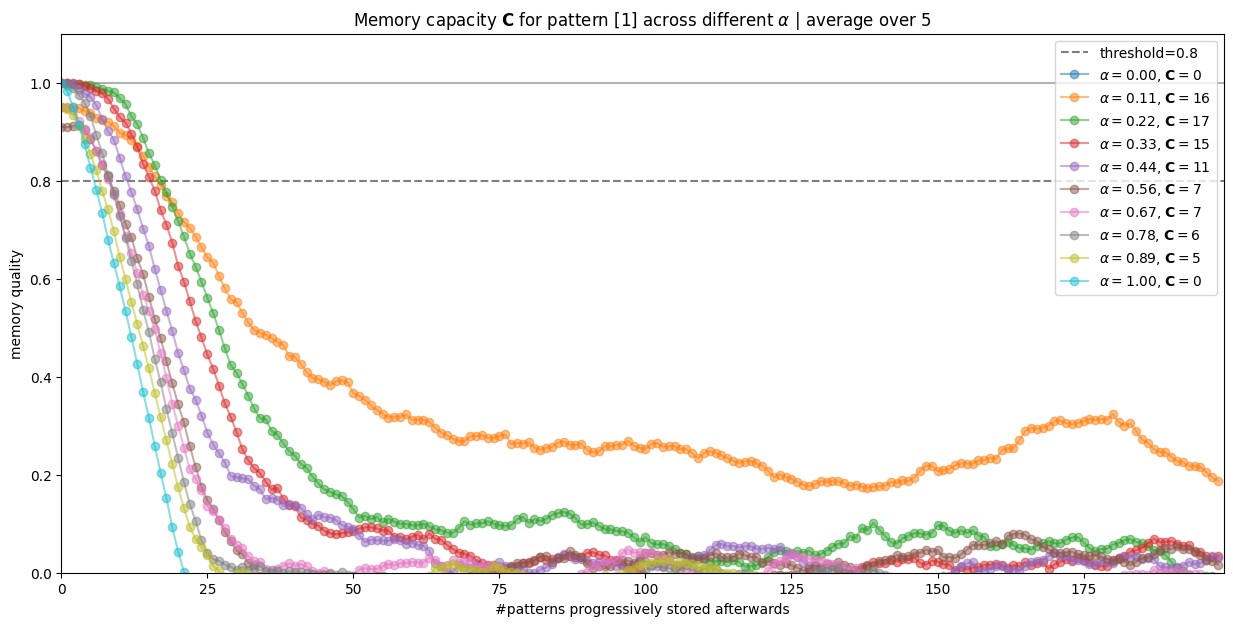

In [17]:
threshold = 0.8
idx_pattern = 1
nsmooth = 20
tot = outputs.shape[-1]

fig1 = plt.figure(figsize=(15, 7))
plt.axhline(threshold, color="black", linestyle="--", label=f"threshold={threshold}", alpha=0.5)
plt.axhline(1., color="black", alpha=0.3)
#plt.axvline(idx_pattern, color="black", alpha=0.3)


for i, out in enumerate(outputs.mean(axis=0)):
    out = out[idx_pattern:]

    # calculate the memory capacity
    capacity = utils.calc_capacity(outputs=out,
                                   threshold=threshold,
                                   nsmooth=nsmooth,
                                   idx_pattern=idx_pattern)

    # smooth
    padded_out = np.pad(out[:, idx_pattern],
                        (nsmooth-1, 0), mode="edge")
    out = np.convolve(padded_out,
                      np.ones(nsmooth)/nsmooth,
                      mode="valid")

    
    plt.plot(range(len(out)), out, 'o-', alpha=0.5, label=f"$\\alpha=${alphas[i]:.2f}, $\mathbf{{C}}=${capacity}")
plt.ylim(0, 1.1)
plt.ylabel("memory quality")
plt.xlim(0, len(out))
plt.xlabel("#patterns progressively stored afterwards")
plt.legend(loc="upper right")
plt.title(f"Memory capacity $\mathbf{{C}}$ for pattern [{idx_pattern}] across different $\\alpha$ | average over {num_rep}")
#plt.grid()
plt.show()

In [14]:
model

MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=True, lr=0.0,beta=60, alpha=1.0, K_l=15, K_o=5

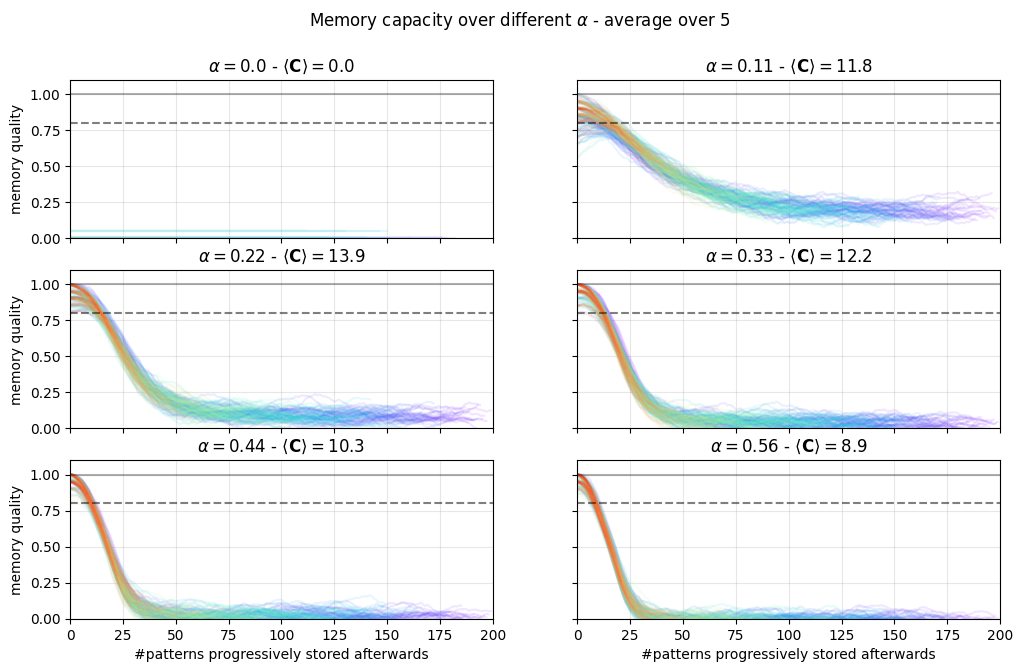

In [18]:
threshold = 0.8
nsmooth = 20
tot = outputs.shape[-1]

fig, axs = plt.subplots(3, 2, figsize=(12, 7), sharex=True, sharey=True)
axs = axs.flatten()
fig.suptitle(f"Memory capacity over different $\\alpha$ - average over {num_rep}")
ia = 0
colors = plt.cm.rainbow(np.linspace(0, 1, tot))  # starts at purple

outs = outputs.mean(axis=0)

for k, ax in enumerate(axs):
    C = 0
    for i in range(tot):
            
        # calculate the memory capacity
        capacity = utils.calc_capacity(outputs=outs[k],
                                       threshold=threshold,
                                       nsmooth=nsmooth,
                                       idx_pattern=i)
        C += capacity
    
        # smooth
        padded_out = np.pad(outs[k, i:, i],
                            (nsmooth-1, 0), mode="edge")
        out = np.convolve(padded_out,
                          np.ones(nsmooth)/nsmooth,
                          mode="valid")
        
        ax.plot(range(len(out)), out, '-', alpha=0.1, color=colors[i])#, label=f"$i=${i}, $\mathbf{{C}}=${capacity}")

    ax.axhline(threshold, color="black", linestyle="--", label=f"threshold={threshold}", alpha=0.5)
    ax.axhline(1., color="black", alpha=0.3)
    ax.set_ylim(0, 1.1)       
    ax.grid(alpha=0.3)
    #ax.legend()
    if k % 2 == 0:
        ax.set_ylabel("memory quality")
    ax.set_xlim(0, tot)
    if k > 3:
        ax.set_xlabel("#patterns progressively stored afterwards")

    ax.set_title(f"$\\alpha=${alphas[k]} - $\\langle \\mathbf{{C}}\\rangle=${C/tot:.1f}")
#plt.grid()
plt.show()

---

#### make animation

In [165]:
from IPython.display import Image
from IPython.display import clear_output
import imageio.v2 as imageio
import time

CACHE_PATH = "../media/cache/"
OBS_PATH = "../media/"


class AnimationMaker:

    def __init__(self, **kwargs):

        """
        Parameters
        ----------
        kwargs : dict
            fps : int
                frames per second, default=10
            use_logger : bool
                use logger, default=True
            path : str
                alternative path to save the animation, default=CACHE_PATH
        """

        self._use_logger = kwargs.get("use_logger", True)
        # self._path = kwargs.get("path", path_dict['cache'])
        self._path = kwargs.get("path", CACHE_PATH)
        self._fps = kwargs.get("fps", 10)
        self._saved_frames = []

        self.anim_name = ""
        self._are_frames = False
        self._is_animation = False

        self._hash = str(np.random.random())[3:10]

        if self._use_logger:
            logger.info(f'AnimationMaker: path={self._path}')

    def add_frame(self, fig: plt.Figure):

        """
        save figure to cache
        
        Parameters
        ----------
        fig : object
            matplotlib.figure.Figure
        """

        name = f"figure_{len(self._saved_frames)}_{self._hash}.png"
        fig.savefig(os.path.join(self._path, f"{name}"), dpi=300)

        self._saved_frames.append(name)

        if not self._are_frames:
            self._are_frames = True

    def delete_frames(self):

        """
        delete all saved figures
        """

        for name in self._saved_frames:
            os.remove(os.path.join(self._path, name))

        self._saved_frames = []
        self._are_frames = False

    def make_animation(self, name: str):

        """
        make animation from saved figures
        
        Parameters
        ----------
        name : str
            name of the animation
        """

        # there should be frames to make animation
        if not self._are_frames:
            logger.warning("!AnimationMaker: no frames to make animation")
            return

        if self._use_logger:
            logger.info(f"AnimationMaker: making animation ({len(self._saved_frames)} frames) ...")

        # create animation
        # with imageio.get_writer(os.path.join(self._path, f'{name}.gif'), mode='I', fps=fps) as writer:
        #     for name in self._saved_frames:
        #         writer.append(imageio.imread(os.path.join(self._path, name)))
        anim = []
        for fig_name in tqdm(self._saved_frames):
            anim += [imageio.imread(os.path.join(self._path, fig_name))]

        imageio.mimsave(os.path.join(self._path, f'{name}.gif'), anim, fps=self._fps)

        self.anim_name = name
        self._is_animation = True

        # delete figures
        self.delete_frames()

        if self._use_logger:
            logger.info(f'AnimationMaker: animation {name}.gif created')

    def save_animation(self, path: str=OBS_PATH, name: str=None, use_timestamp: bool=True):

        """
        save the animation gif in the new path

        Parameters
        ----------
        path : str
            path to save the animation, default=OBS_PATH
        name : str
            name of the animation, default=None
        use_timestamp : bool
            use timestamp in the name, default=True
        """

        if not self._is_animation:
            logger.warning('!AnimationMaker: no animation to save')
            return


        name = name if name is not None else self.anim_name

        if use_timestamp:
            timestamp = generate_timestamp()
            name = f'{timestamp}_{name}'

        # animation current path 
        anim_path = os.path.join(self._path, f'{name}.gif')

        # target path 
        # path = os.path.join(path, f'{self.anim_name}.gif')

        # move animation.gif to new path
        os.system(f"mv {anim_path} {path}")      # anim = imageio.mimread(os.path.join(self._path, f'{self.anim_name}.gif'))

        # # save in new path 
        # imageio.mimsave(os.path.join(path, f'{self.anim_name}.gif'), anim)

        # # delete old anim
        # os.remove(os.path.join(self._path, f'{self.anim_name}.gif'))

        if self._use_logger:
            logger.info(f'AnimationMaker: animation {self.anim_name}.gif saved in {path}')

    def delete_animation(self):

        """
        delete the animation
        """

        if not self._is_animation:
            logger.warning('!AnimationMaker: no animation to delete')
            return

        os.remove(os.path.join(self._path, f'{self.anim_name}.gif'))

        self._is_animation = False

        if self._use_logger:
            logger.info(f'AnimationMaker: animation {self.anim_name}.gif deleted')

    def play_animation(self, **kwargs) -> Image:

        """
        play the animation

        Parameters
        ----------
        kwargs : dict
            return_Image : bool
                return the animation as Image object, default False

        Returns
        -------
        Image : object
            IPython.display.Image
        """

        # there should be an animation to play
        if not self._is_animation:
            logger.warning('!AnimationMaker: no animation to play')
            return

        # play anim
        if kwargs.get("return_Image", False):
            return Image(open(os.path.join(self._path, f'{self.anim_name}.gif'), 'rb').read(),
                     width=kwargs.get('width', 500),
                     height=kwargs.get('height', 500))

        os.system(f"open {os.path.join(self._path, f'{self.anim_name}.gif')} -a Brave")


2024-09-02 19:37:27 | AnimationMaker: path=media/
2024-09-02 19:37:33 | AnimationMaker: making animation (20 frames) ...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.25it/s]
2024-09-02 19:37:35 | AnimationMaker: animation rcapacities_193733.gif created


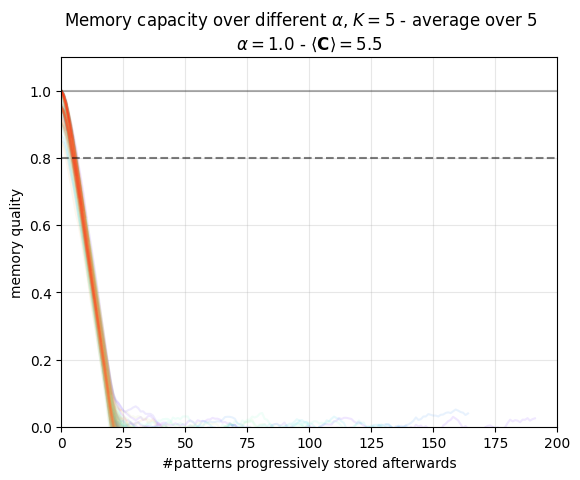

In [174]:
threshold = 0.8
nsmooth = 20
tot = outputs.shape[-1]
#alphas = [0.01, 0.04, 0.08, 0.2, 0.6, 1.]

fig, ax = plt.subplots()
fig.suptitle(f"Memory capacity over different $\\alpha$, $K=${K} - average over {num_rep}")
animation_maker = AnimationMaker(fps=3,
                                 use_logger=True,
                                 path=r"media/")


ia = 0
colors = plt.cm.rainbow(np.linspace(0, 1, tot))  # starts at purple

outs = outputs.mean(axis=0)
Cs = []

for k in range(len(alphas)):
    C = 0
    ax.clear()
    for i in range(tot):
            
        # calculate the memory capacity
        capacity = utils.calc_capacity(outputs=outs[k],
                                       threshold=threshold,
                                       nsmooth=nsmooth,
                                       idx_pattern=i)
        C += capacity
    
        # smooth
        padded_out = np.pad(outs[k, i:, i],
                            (nsmooth-1, 0), mode="edge")
        out = np.convolve(padded_out,
                          np.ones(nsmooth)/nsmooth,
                          mode="valid")
        
        ax.plot(range(len(out)), out, '-', alpha=0.1, color=colors[i])#, label=f"$i=${i}, $\mathbf{{C}}=${capacity}")

    Cs += [C/tot]
    ax.axhline(threshold, color="black", linestyle="--", label=f"threshold={threshold}", alpha=0.5)
    ax.axhline(1., color="black", alpha=0.3)
    ax.set_ylim(0, 1.1)       
    ax.grid(alpha=0.3)
    #ax.legend()
    ax.set_ylabel("memory quality")
    ax.set_xlim(0, tot)
    ax.set_xlabel("#patterns progressively stored afterwards")

    ax.set_title(f"$\\alpha=${alphas[k]} - $\\langle \\mathbf{{C}}\\rangle=${C/tot:.1f}")
    animation_maker.add_frame(fig)

#
animation_maker.make_animation(
    name=f"rcapacities_{time.strftime('%H%M%S')}")

animation_maker.play_animation(return_Image=False)


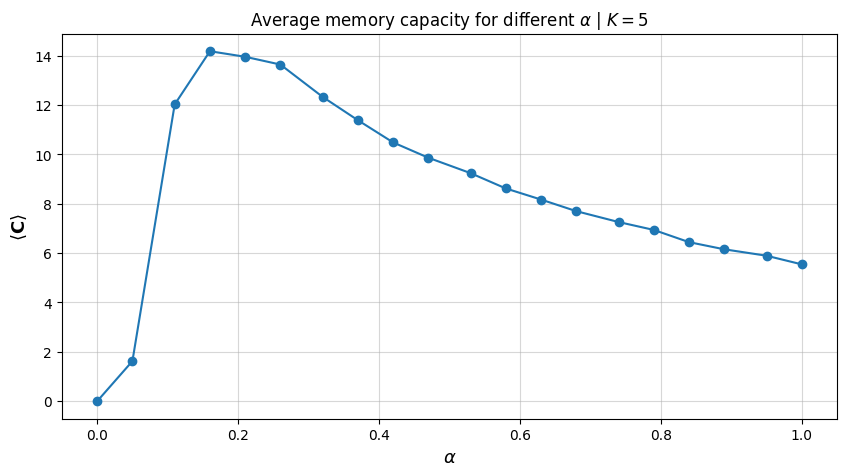

In [179]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(alphas, Cs, 'o-')

#plt.ylim((0, 5))
ax.set_ylabel("$\\langle\mathbf{C}\\rangle$", fontsize=13)
ax.set_xlabel("$\\alpha$", fontsize=13)
ax.set_title(f"Average memory capacity for different $\\alpha$ | $K=${K}")
ax.grid(alpha=0.5)
plt.show()

In [156]:
capacity = utils.calc_capacity(outputs=outs[k],
                                       threshold=threshold,
                                       nsmooth=nsmooth,
                                       idx_pattern=None)
capacity

ValueError: object too deep for desired array